In [4]:
import pandas as pd
import numpy as np
import spacy
import re
import pyLDAvis.gensim
import warnings

from gensim.models import Phrases, LdaModel, TfidfModel, LsiModel, CoherenceModel
from gensim.corpora import Dictionary

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import LatentDirichletAllocation

from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt
%matplotlib inline

#from stop_words import get_stop_words

pyLDAvis.enable_notebook()
warnings.filterwarnings("ignore", category=DeprecationWarning) 


C:\Users\SRYS\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [5]:
df = pd.read_excel("Data\Bourso_Natixis.xlsx")

In [6]:
df.columns, df.shape

(Index(['ID', 'CLIENT', 'DATE', 'DATE_CONTRAT', 'AGE', 'RAISON', 'RESILIATION',
        'SATISFACTION', 'AMABILITE', 'COMPREHENSION', 'SOLUTION',
        'DEPUIS_APPEL', 'VERBATIM', 'AVANT_RESILIATION', 'RESILIATION_AN'],
       dtype='object'),
 (13622, 15))

In [7]:
nlp = spacy.blank("fr")

In [8]:
textes = df[df["VERBATIM"].notnull()]["VERBATIM"]
type(textes), textes.shape

(pandas.core.series.Series, (10072,))

In [9]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('french')

In [10]:
%time spacy_docs = list(nlp.pipe(textes))

Wall time: 754 ms


In [11]:
docs = [[t.lemma_.lower() for t in doc if len(t.orth_) > 4 and not t.is_stop] for doc in spacy_docs]
print(docs[:3])

[['problème', 'banque'], ['assurance', 'téléphone', 'accidentel', 'assuré', 'pipeau', 'encadré', 'définition', 'accidentel', 'douteuse', 'fallacieuse', 'empêche', 'accidentel', 'charge', 'assurance', 'merde', 'contact', 'désagréable', 'raccrocher', 'assuré', 'étonne', 'pouvoir', 'retrouvé', 'informatiquement', 'insinuations', 'douteuses', 'réponses', 'hasardeuses', 'sorties', 'chapeau', 'combler', 'laissé', 'réponses', 'tomber', 'terre', 'train', 'résilier', 'assurances', 'maisons', 'paiements', 'mobile', 'continuer', 'extorquer', 'pigeons', 'pardon', 'clients', 'toussote'], ['conseiller', 'agréable', 'répondait', 'questions', 'préférait', 'discussion', 'engagé', 'sorte', 'travail', 'chaîne', 'temps', 'moderne', 'finir', 'client', 'rapidement', 'prendre', 'ligne', 'relation', 'client', 'triste']]


In [12]:
bigram = Phrases(docs, min_count=10)

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:  # les bigrammes peuvent être reconnus par "_" qui concatène les mots
            docs[idx].append(token)

In [13]:
docs[2]

['conseiller',
 'agréable',
 'répondait',
 'questions',
 'préférait',
 'discussion',
 'engagé',
 'sorte',
 'travail',
 'chaîne',
 'temps',
 'moderne',
 'finir',
 'client',
 'rapidement',
 'prendre',
 'ligne',
 'relation',
 'client',
 'triste']

# Constructing a document-term matrix

To generate an LDA model, we need to understand how frequently each term occurs within each document. To do that, we need to construct a document-term matrix with a package called gensim:

In [14]:
dictionary = Dictionary(docs)
print('Number of unique words in original documents :', len(dictionary))

dictionary.filter_extremes(no_below=3, no_above=0.25)
print('Number of unique words after removing rare and common words :', len(dictionary))

print("Example representation of document 3 :", dictionary.doc2bow(docs[2]))

Number of unique words in original documents : 5814
Number of unique words after removing rare and common words : 2075
Example representation of document 3 : [(26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)]


The Dictionary() function traverses texts, assigning a unique integer id to each unique token while also collecting word counts and relevant statistics. To see each token’s unique integer id, try print(dictionary.token2id).

Next, our dictionary must be converted into a bag-of-words:

In [15]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

The doc2bow() function converts dictionary into a bag-of-words. The result, corpus, is a list of vectors equal to the number of documents. In each document vector is a series of tuples. As an example, print(corpus[0]) results in the following:

In [16]:
print(corpus[0])

[(0, 1), (1, 1)]


corpus is a document-term matrix and now we’re ready to generate an LDA model:

# Create the TF-IDF model

In [17]:
tfidf = TfidfModel(corpus, smartirs='ntc')
corpus_tfidf = tfidf[corpus]

# Applying the LDA model

## Get the optimal num_topic for LDA model
Function to calculate the coherence score with varying num_topics parameter

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2):
    coherence_values = []
    model_list = []
    log_perplexity = []
    for num_topics in range(start, limit+1):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, chunksize=1000, passes=5, random_state=1)
        model_list.append(model)
        log_perplexity.append(model.log_perplexity(corpus))
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values, log_perplexity

In [19]:
limit=20; start=2;
model_list, coherence_values, log_perplexity = compute_coherence_values(dictionary, corpus, docs, limit=limit, start=start)

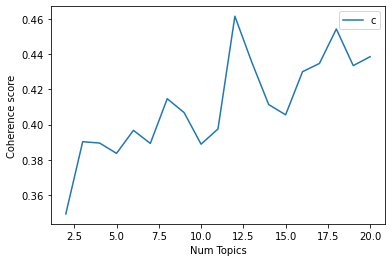

In [20]:
# Show graph
x = range(start, limit+1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

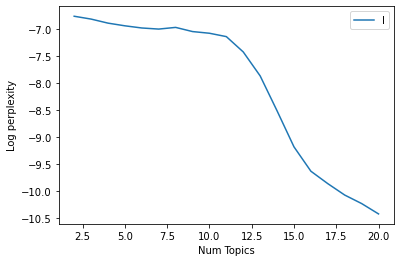

In [21]:
# Show graph
x = range(start, limit+1)
plt.plot(x, log_perplexity)
plt.xlabel("Num Topics")
plt.ylabel("Log perplexity")
plt.legend(("log_perplexity"), loc='best')
plt.show()

In [22]:
# Select the model and print the topics
optimal_model = model_list[5]
optimal_model

In [23]:
%time model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=8, chunksize=1000, passes=5, random_state=1)

Wall time: 9.44 s


The LdaModel class is described in detail in the gensim documentation. Parameters used in our example:

Parameters:
- num_topics: required. An LDA model requires the user to determine how many topics should be generated. Our document set is small, so we’re only asking for three topics.
- id2word: required. The LdaModel class requires our previous dictionary to map ids to strings.
- passes: optional. The number of laps the model will take through corpus. The greater the number of passes, the more accurate the model will be. A lot of passes can be slow on a very large corpus.


In [24]:
for (topic, words) in model.print_topics():
    print("***********")
    print("* topic", topic+1, "*")
    print("***********")
    print(topic+1, ":", words)
    print()

***********
* topic 1 *
***********
1 : 0.058*"accueil" + 0.053*"satisfaite" + 0.050*"rapide" + 0.043*"contact" + 0.041*"téléphonique" + 0.040*"efficace" + 0.036*"réponse" + 0.026*"suite" + 0.023*"démarches" + 0.021*"agréable"

***********
* topic 2 *
***********
2 : 0.255*"signaler" + 0.057*"parfait" + 0.024*"ajouter" + 0.022*"traiter" + 0.021*"cotisation" + 0.016*"professionnelle" + 0.015*"meilleure" + 0.013*"normal" + 0.013*"monde" + 0.012*"protection"

***********
* topic 3 *
***********
3 : 0.062*"prise" + 0.055*"charge" + 0.054*"sinistre" + 0.039*"prise_charge" + 0.031*"demande" + 0.029*"téléphone" + 0.028*"déclaration" + 0.023*"compte" + 0.022*"réponse" + 0.020*"attente"

***********
* topic 4 *
***********
4 : 0.045*"assurance" + 0.039*"temps" + 0.025*"manque" + 0.024*"client" + 0.022*"problème" + 0.021*"service" + 0.021*"téléphone" + 0.021*"services" + 0.019*"réparation" + 0.019*"assurances"

***********
* topic 5 *
***********
5 : 0.092*"satisfait" + 0.079*"service" + 0.045*"

In [29]:
pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.047049  0.227143       1        1  11.810321
1     -0.074671 -0.254063       2        1   8.327597
2      0.263940  0.012342       3        1  15.591470
3     -0.083377 -0.080254       4        1  16.228876
4     -0.170043  0.033877       5        1   9.637988
5     -0.115072 -0.167543       6        1  11.559565
6      0.315644 -0.027976       7        1  15.284942
7     -0.089372  0.256473       8        1  11.559241, topic_info=           Term        Freq       Total Category  logprob  loglift
265    signaler  987.000000  987.000000  Default  30.0000  30.0000
95    satisfait  411.000000  411.000000  Default  29.0000  29.0000
188     service  664.000000  664.000000  Default  28.0000  28.0000
171       prise  449.000000  449.000000  Default  27.0000  27.0000
116    sinistre  720.000000  720.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
55      réponse   74.632515  569.879485   Topic8  -4.2746   0.1248
28   conseiller   55.669420  162.163143   Topic8  -4.5677   1.0885
327      rapide   55.409845  331.632745   Topic8  -4.5724   0.3684
125       suite   54.146025  429.651909   Topic8  -4.5954   0.0864
26     agréable   49.433271  164.442674   Topic8  -4.6865   0.9557

[370 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
190       6  0.981589            abonnement
794       3  0.981567          accidentelle
399       1  0.701057               accueil
399       8  0.298557               accueil
423       1  0.990950  accueil_téléphonique
...     ...       ...                   ...
57        7  0.102974                 voler
199       6  0.991080              vraiment
126       8  0.994090               échange
131       8  0.997215                écoute
1676      8  0.976875               évaluer

[438 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

In [25]:
# Nous en affichons que 8
i = 0
for (text, doc) in zip(textes[:8], docs[:8]):
    i += 1
    print("***********")
    print("* doc", i, "  *")
    print("***********")
    print(text)
    print([(topic+1, prob) for (topic, prob) in model[dictionary.doc2bow(doc)] if prob > 0.1])
    print()

***********
* doc 1   *
***********
 ! pas de problème avec ma banque
[(4, 0.38344425), (6, 0.3664633)]

***********
* doc 2   *
***********
 " Assurance bris de téléphone accidentel "   ( assuré compris )  ,  un beau pipeau encadré par une définition de  " bris accidentel "  plus que douteuse ,  voir fallacieuse qui empêche tout *vrai*  bris accidentel d ' être pris en charge .  .  . Bref assurance de merde ,  contact désagréable au possible et qui se permet de raccrocher au nez quand l ' assuré s ' étonne de ne pouvoir être retrouvé informatiquement .  Des insinuations douteuses et des réponses hasardeuses sorties du chapeau pour combler le vide laissé par certaines réponses a tomber par terre .  .  .  .  . Bref ,  je suis en train de résilier toutes mes assurances chez vous  ( Maisons ,  paiements ,  mobile etc. .  .  .  )  ,  bon vent et continuer à extorquer vos pigeons ,  pardon vos *clients*  ( *toussote* )  ,  mais sans moi . 
[(4, 0.8147666)]

***********
* doc 3   *
*********

# Finding the dominant topic in each sentence

In [26]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    #contents = pd.Series(texts)
    contents = pd.DataFrame(texts).reset_index()
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=textes)

# Format
df_dominant_topic = df_topic_sents_keywords.set_index('index')
df_dominant_topic.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
index,,,,
44,3.0,0.3834,"assurance, temps, manque, client, problème, se...",! pas de problème avec ma banque
45,3.0,0.8148,"assurance, temps, manque, client, problème, se...",""" Assurance bris de téléphone accidentel "" ..."
46,0.0,0.6237,"accueil, satisfaite, rapide, contact, téléphon...",""" Conseiller "" peu agréable qui ne répondait..."
47,7.0,0.8750,"bonne, écoute, interlocuteur, aimable, échange...",""" Le sourire s ' entend au téléphone "" , él..."
48,6.0,0.5253,"dossier, sinistre, déclaration, faire, suite, ...",""" Votre portable est assuré pour un vol ayant..."
49,1.0,0.5312,"signaler, parfait, ajouter, traiter, cotisatio...",# en fin de communication pour avoir un inte...
54,2.0,0.5199,"prise, charge, sinistre, prise_charge, demande...",& # 270 . dossier en cours depuis le 3 mars ...
55,4.0,0.3340,"satisfait, service, amabilité, question, quest...",( bris de tel ) pas de réponse à ma questio...
56,5.0,0.6249,"carte, banque, remarque, faire, service, clair...",( Forcément ) déçu que les conditions évoqué...


In [27]:
def format_topics_sentences_second(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 1 and prop_topic > 0.1:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)
            elif j == 1 and prop_topic <= 0.1:
                sent_topics_df = sent_topics_df.append(pd.Series([None , None ]), ignore_index=True)
            elif len(row)==1:
                sent_topics_df = sent_topics_df.append(pd.Series([None , None ]), ignore_index=True)

    sent_topics_df.columns = ['Second_Topic', 'Perc_Contrib_Second']

    # Add original text to the end of the output
    #contents = pd.Series(texts)
    contents = pd.DataFrame(texts).reset_index()
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords_second = format_topics_sentences_second(ldamodel=model, corpus=corpus, texts=textes)

# Format
df_dominant_topic_second = df_topic_sents_keywords_second.set_index('index')
df_dominant_topic_second.columns = ['Second_Topic', 'Perc_Contrib_Second', 'Text']

# Show
df_dominant_topic_second.head(10)

,Second_Topic,Perc_Contrib_Second,Text
index,,,
44,5.0,0.3665,! pas de problème avec ma banque
45,NaN,NaN,""" Assurance bris de téléphone accidentel "" ..."
46,3.0,0.2060,""" Conseiller "" peu agréable qui ne répondait..."
47,NaN,NaN,""" Le sourire s ' entend au téléphone "" , él..."
48,2.0,0.3620,""" Votre portable est assuré pour un vol ayant..."
49,7.0,0.2812,# en fin de communication pour avoir un inte...
54,6.0,0.3188,& # 270 . dossier en cours depuis le 3 mars ...
55,2.0,0.3158,( bris de tel ) pas de réponse à ma questio...
56,3.0,0.2250,( Forcément ) déçu que les conditions évoqué...


In [28]:
pd.concat([df,df_dominant_topic,df_dominant_topic_second.drop("Text",axis=1)],axis=1).to_excel('Data\Bourso_Natixis_Topics.xlsx',index=False)

# Find the most representative document for each topic

In [29]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.drop('index',axis=1).groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8750,"accueil, satisfaite, rapide, contact, téléphon...",a la suite du vol de mon sac à main mon contac...
1,1.0,0.8905,"signaler, parfait, ajouter, traiter, cotisatio...",15 euros l ' opposition pour un chèque ca fa...
2,2.0,0.9708,"prise, charge, sinistre, prise_charge, demande...",À heure d'internet et de l'écologie envers les...
3,3.0,0.9583,"assurance, temps, manque, client, problème, se...",Assurance inutile . Le but avec une assurance...
4,4.0,0.9204,"satisfait, service, amabilité, question, quest...",2 appels au service securi . Le 1er a été trè...
5,5.0,0.8906,"carte, banque, remarque, faire, service, clair...",Perte de ma carte d ' identité et carte vitale...
6,6.0,0.9125,"dossier, sinistre, déclaration, faire, suite, ...",Je n ' ai toujours pas reçu les documents à re...
7,7.0,0.9204,"bonne, écoute, interlocuteur, aimable, échange...",Accent étranger qui ne facilite pas la compréh...


# Topic distribution across documents

In [30]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4).to_frame(name='Perc_Documents')

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()
topic_num_keywords = topic_num_keywords.set_index(pd.Series(topic_num_keywords.Dominant_Topic.values))

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts.to_frame(name='Num_Documents'), topic_contribution], axis=1)

# Change Column names
#df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"accueil, satisfaite, rapide, contact, téléphon...",2136,0.2121
1.0,1.0,"signaler, parfait, ajouter, traiter, cotisatio...",1585,0.1574
2.0,2.0,"prise, charge, sinistre, prise_charge, demande...",1027,0.1020
3.0,3.0,"assurance, temps, manque, client, problème, se...",1017,0.1010
4.0,4.0,"satisfait, service, amabilité, question, quest...",837,0.0831
5.0,5.0,"carte, banque, remarque, faire, service, clair...",1033,0.1026
6.0,6.0,"dossier, sinistre, déclaration, faire, suite, ...",1124,0.1116
7.0,7.0,"bonne, écoute, interlocuteur, aimable, échange...",1313,0.1304


In [35]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pydeepl

vader = SentimentIntensityAnalyzer()

for toto in textes[:8]:
    print(toto)
    translate = pydeepl.translate(toto, 'EN', 'FR')
    print(translate)
    #print(vader.polarity_scores(translate))

 ! pas de problème avec ma banque


TranslationError: DeepL call resulted in a unknown result.

# Prediction

In [15]:
data = pd.concat([df,df_dominant_topic,df_dominant_topic_second.drop("Text",axis=1)],axis=1) 
data = data[['SATISFACTION','RESILIATION','AGE','Dominant_Topic','Topic_Perc_Contrib','Second_Topic','Perc_Contrib_Second']]
data = data.dropna()
data.shape, data.columns

((6229, 7),
 Index(['SATISFACTION', 'RESILIATION', 'AGE', 'Dominant_Topic',
        'Topic_Perc_Contrib', 'Second_Topic', 'Perc_Contrib_Second'],
       dtype='object'))

In [16]:
from sklearn.preprocessing import LabelEncoder

y = LabelEncoder().fit_transform(data['RESILIATION'])
y.shape

(6229,)

In [17]:
x_satisfaction = pd.get_dummies(data.SATISFACTION)
x_dominant = pd.get_dummies(data.Dominant_Topic, prefix='Dominant_Topic')
x_second = pd.get_dummies(data.Second_Topic, prefix='Second_Topic')

In [18]:
X = x_satisfaction.join(x_dominant).join(x_second).join(data.AGE)
X.shape

(6229, 19)

In [19]:
data_dominant = data[['Dominant_Topic','Topic_Perc_Contrib']]
data_dominant = pd.pivot_table(data_dominant,index=data_dominant.index,columns='Dominant_Topic',values='Topic_Perc_Contrib', fill_value=0)
data_dominant.columns = ['Dominant_' + str(col) for col in data_dominant.columns]
data_dominant.shape

(6229, 8)

In [20]:
data_second = data[['Second_Topic','Perc_Contrib_Second']]
data_second = pd.pivot_table(data_second,index=data_second.index,columns='Second_Topic',values='Perc_Contrib_Second', fill_value=0)
data_second.columns = ['Second_' + str(col) for col in data_second.columns]
data_second.shape

(6229, 8)

In [21]:
X_final = X.join(data_dominant).join(data_second)
X_final.shape

(6229, 35)

In [36]:
import statsmodels.api as sm
# on ajoute une colonne pour la constante
x_stat = sm.add_constant(X_final)
# on ajuste le modèle
model = sm.Logit(y, x_stat)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.402606
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 6231
Model:                          Logit   Df Residuals:                     6198
Method:                           MLE   Df Model:                           32
Date:                Mon, 06 Apr 2020   Pseudo R-squ.:                0.008429
Time:                        13:30:08   Log-Likelihood:                -2508.6
converged:                       True   LL-Null:                       -2530.0
Covariance Type:            nonrobust   LLR p-value:                   0.09881
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.5741   3.06e+06  -1.87e-07      1.000   -6.01e+06    6.01e+06
Insatisfait           -0.7192        nan        nan        nan         nan         nan
Satisfait             -0.8172        nan        nan        nan         nan         nan
Dominant_Topic_0.0     0.2837        nan        nan        nan         nan         nan
Dominant_Topic_1.0    -0.2742        nan        nan        nan         nan         nan
Dominant_Topic_2.0    -0.1674        nan        nan        nan         nan         nan
Dominant_Topic_3.0    -0.3343        nan        nan        nan         nan         nan
Dominant_Topic_4.0    -1.3046        nan        nan        nan         nan         nan
Dominant_Topic_5.0    -0.0519        nan        nan        nan         nan         nan
Dominant_Topic_6.0     0.2726        nan        nan        nan         nan         nan
Dominant_Topic_7.0     0.1048        nan        nan        nan         nan         nan
Second_Topic_0.0       0.7113   6.06e+06   1.17e-07      1.000   -1.19e+07    1.19e+07
Second_Topic_1.0      -0.6977   6.06e+06  -1.15e-07      1.000   -1.19e+07    1.19e+07
Second_Topic_2.0       0.1000   6.06e+06   1.65e-08      1.000   -1.19e+07    1.19e+07
Second_Topic_3.0      -0.2920   6.06e+06  -4.82e-08      1.000   -1.19e+07    1.19e+07
Second_Topic_4.0       0.0684   6.06e+06   1.13e-08      1.000   -1.19e+07    1.19e+07
Second_Topic_5.0      -0.2372   6.06e+06  -3.91e-08      1.000   -1.19e+07    1.19e+07
Second_Topic_6.0      -0.4857   6.06e+06  -8.01e-08      1.000   -1.19e+07    1.19e+07
Second_Topic_7.0      -0.1063   6.06e+06  -1.75e-08      1.000   -1.19e+07    1.19e+07
AGE                   -0.0059      0.002     -2.756      0.006      -0.010      -0.002
Dominant_0.0          -0.5220      0.660     -0.791      0.429      -1.815       0.771
Dominant_1.0          -0.1789      1.927     -0.093      0.926      -3.955       3.598
Dominant_2.0           0.1028      0.774      0.133      0.894      -1.415       1.620
Dominant_3.0           0.2950      0.835      0.353      0.724      -1.341       1.931
Dominant_4.0           2.8155      1.129      2.494      0.013       0.603       5.028
Dominant_5.0           0.2003      1.014      0.197      0.843      -1.788       2.188
Dominant_6.0          -0.5270      0.743     -0.709      0.478      -1.984       0.930
Dominant_7.0          -0.7028      0.880     -0.799      0.425      -2.428       1.022
Second_0.0            -3.1331      1.550     -2.022      0.043      -6.171      -0.095
Second_1.0             2.1442      1.508      1.422      0.155      -0.811       5.099
Second_2.0            -0.1939      1.457     -0.133      0.894      -3.049       2.661
Second_3.0             1.2454      1.350      0.923      0.356      -1.400       3.891
Second_4.0            -0.1768      1.446     -0.122      0.903      -3.012       2.658
Second_5.0             0.9471      1.663      0.570      0.569      -2.312       4.206
Second_6.0            

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, matthews_corrcoef
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [30]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
logreg.fit(X_train, y_train)

pd.DataFrame(np.concatenate([logreg.intercept_.reshape(-1,1),
                             logreg.coef_],axis=1),
             index = ["coef"],
             columns = ["constante"]+list(X_train.columns)).T

,coef
constante,-0.836535
Insatisfait,-0.383947
Satisfait,-0.452588
Dominant_Topic_0.0,-0.031540
Dominant_Topic_1.0,-0.278787
Dominant_Topic_2.0,-0.086379
Dominant_Topic_3.0,-0.172527
Dominant_Topic_4.0,0.066711
Dominant_Topic_5.0,-0.102359
Dominant_Topic_6.0,0.010081


## Logistic Regression

In [31]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(matthews_corrcoef(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.86
0.0
[[1603    0]
 [ 266    0]]


C:\Users\SRYS\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


## Naive Bayesian

In [53]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(gnb.score(X_test, y_test)))
print(matthews_corrcoef(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.83
-0.033693828760736205
[[1553   50]
 [ 262    4]]


## XgBoost

In [33]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(xgb.score(X_test, y_test)))
print(matthews_corrcoef(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.85
0.03559409162215401
[[1581   22]
 [ 259    7]]


In [676]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1603
           1       0.06      0.00      0.01       266

    accuracy                           0.85      1869
   macro avg       0.46      0.50      0.46      1869
weighted avg       0.74      0.85      0.79      1869



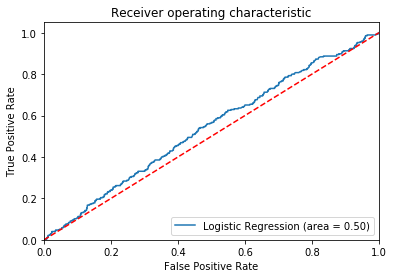

In [43]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [51]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import matthews_corrcoef
from imblearn.pipeline import Pipeline

# summarize class distribution
counter = Counter(y_train)
print(counter)

# transform the dataset
X_ros, y_ros = RandomOverSampler().fit_resample(X_train, y_train)
X_smote, y_smote = SMOTE().fit_resample(X_train, y_train)
X_adasyn, y_adasyn = ADASYN().fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y_ros)
print(counter)

# summarize the new class distribution
counter = Counter(y_smote)
print(counter)

# summarize the new class distribution
counter = Counter(y_adasyn)
print(counter)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print('Central ',matthews_corrcoef(y_test, y_pred))

xgb.fit(X_smote, y_smote)
y_pred_smote = xgb.predict(X_test)
print('SMOTE ',matthews_corrcoef(y_test, y_pred_smote))

xgb.fit(X_adasyn, y_adasyn)
y_pred_adasyn = xgb.predict(X_test)
print('ADASYN ',matthews_corrcoef(y_test, y_pred_adasyn))

Counter({0: 3760, 1: 601})
Counter({0: 3760, 1: 3760})
Counter({0: 3760, 1: 3760})
Counter({1: 3799, 0: 3760})
Central  0.011301058393680173
SMOTE  0.02187098728845684
ADASYN  0.03194802530260964


In [739]:
# define pipeline
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_transformed, y_transformed = pipeline.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y_transformed)
print(counter)

logreg.fit(X_transformed, y_transformed)
y_pred_over_under = logreg.predict(X_test)
print(matthews_corrcoef(y_test, y_pred_over_under))

Counter({1: 2620, 0: 1310})
0.26255511337714005


# Latent Semantic Indexing model

In [36]:
lsi = LsiModel(corpus_tfidf,id2word=dictionary,num_topics=8)
corpus_lsi = lsi[corpus_tfidf]
lsi.print_topics()

[(0,
  '-1.000*"signaler" + -0.004*"parfait" + -0.002*"contact" + -0.002*"satisfaite" + -0.001*"problème" + -0.001*"attente" + -0.001*"demande" + -0.001*"efficace" + -0.001*"rapide" + -0.001*"dossier"'),
 (1,
  '0.994*"remarque" + 0.085*"faire" + 0.029*"satisfait" + 0.028*"satisfaite" + 0.024*"suggestion" + 0.022*"remarque_suggestion" + 0.018*"parfait" + 0.018*"service" + 0.011*"formuler" + 0.009*"instant"'),
 (2,
  '0.969*"satisfait" + 0.113*"service" + 0.096*"accueil" + 0.070*"parfait" + 0.047*"rapide" + 0.044*"réponse" + 0.040*"efficace" + 0.039*"écoute" + -0.038*"remarque" + 0.037*"contact"'),
 (3,
  '0.976*"parfait" + -0.113*"satisfait" + 0.099*"service" + 0.061*"accueil" + 0.059*"rapide" + 0.049*"efficace" + 0.036*"contact" + 0.033*"aimable" + 0.032*"satisfaite" + 0.027*"écoute"'),
 (4,
  '-0.415*"accueil" + -0.379*"satisfaite" + -0.290*"rapide" + -0.288*"efficace" + -0.248*"service" + 0.195*"satisfait" + 0.188*"parfait" + -0.171*"écoute" + -0.170*"réponse" + -0.144*"contact"'),


# CountVectorizer

In [37]:
cd = CountVectorizer(min_df=2)
cd.fit(textes)
res = cd.transform(textes)
res

<10072x3596 sparse matrix of type '<class 'numpy.int64'>'
	with 110149 stored elements in Compressed Sparse Row format>

In [38]:
res.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 2, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0]], dtype=int64)

In [39]:
cd.vocabulary_

{'pas': 2296,
 'de': 957,
 'problème': 2514,
 'avec': 425,
 'ma': 1932,
 'banque': 451,
 'assurance': 347,
 'bris': 526,
 'téléphone': 3356,
 'accidentel': 118,
 'assuré': 353,
 'compris': 729,
 'un': 3367,
 'beau': 461,
 'par': 2255,
 'une': 3368,
 'définition': 1146,
 'plus': 2407,
 'que': 2629,
 'voir': 3454,
 'qui': 2643,
 'empêche': 1237,
 'tout': 3300,
 'vrai': 3485,
 'être': 3594,
 'pris': 2507,
 'en': 1239,
 'charge': 610,
 'bref': 521,
 'merde': 2005,
 'contact': 830,
 'désagréable': 1184,
 'au': 376,
 'possible': 2440,
 'et': 1336,
 'se': 2994,
 'permet': 2340,
 'raccrocher': 2651,
 'nez': 2113,
 'quand': 2624,
 'ne': 2109,
 'pouvoir': 2473,
 'retrouvé': 2845,
 'des': 982,
 'réponses': 2931,
 'du': 1100,
 'chapeau': 608,
 'pour': 2452,
 'le': 1866,
 'vide': 3428,
 'laissé': 1862,
 'certaines': 588,
 'tomber': 3286,
 'terre': 3266,
 'je': 1825,
 'suis': 3175,
 'train': 3304,
 'résilier': 2942,
 'toutes': 3303,
 'mes': 2006,
 'assurances': 348,
 'chez': 624,
 'vous': 3483,
 'ma

In [40]:
cd.stop_words

In [43]:
count_vect = CountVectorizer(tokenizer=word_tokenize)
counts = count_vect.fit_transform(textes)
counts.shape

(10072, 6952)

In [44]:
counts.todense()

matrix([[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [45]:
cd = HashingVectorizer(n_features=5)
cd.fit(textes)
res = cd.transform(textes)
res.todense()

matrix([[ 0.        , -0.53452248, -0.26726124,  0.80178373,  0.        ],
        [-0.54935027, -0.08451543,  0.04225771,  0.80289654, -0.21128856],
        [-0.47140452,  0.23570226, -0.47140452,  0.        ,  0.70710678],
        ...,
        [ 0.        , -0.16012815,  0.48038446,  0.32025631,  0.80064077],
        [ 0.        ,  0.        ,  0.70710678, -0.70710678,  0.        ],
        [ 0.        , -0.33333333,  0.        ,  0.66666667, -0.66666667]])

In [46]:
cd = HashingVectorizer(n_features=5, binary=True)
cd.fit(textes)
res = cd.transform(textes)
res.todense()

matrix([[0.        , 0.57735027, 0.57735027, 0.57735027, 0.        ],
        [0.4472136 , 0.4472136 , 0.4472136 , 0.4472136 , 0.4472136 ],
        [0.4472136 , 0.4472136 , 0.4472136 , 0.4472136 , 0.4472136 ],
        ...,
        [0.4472136 , 0.4472136 , 0.4472136 , 0.4472136 , 0.4472136 ],
        [0.4472136 , 0.4472136 , 0.4472136 , 0.4472136 , 0.4472136 ],
        [0.4472136 , 0.4472136 , 0.4472136 , 0.4472136 , 0.4472136 ]])

In [47]:
cd = TfidfVectorizer()
cd.fit(textes)
res = cd.transform(textes)
res.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.11305922, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.25706367, 0.        ,
         0.        ]])

In [48]:
pipe = make_pipeline(CountVectorizer(), TfidfTransformer())
pipe.fit(textes)
res = pipe.transform(textes)
res.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.11305922, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.25706367, 0.        ,
         0.        ]])

In [49]:
pipe = make_pipeline(HashingVectorizer(n_features=5), TfidfTransformer())
pipe.fit(textes)
res = pipe.transform(textes)
res.todense()

matrix([[ 0.        , -0.59534167, -0.29452508,  0.74754483,  0.        ],
        [-0.51615918, -0.10193152,  0.05042716,  0.81060969, -0.25210852],
        [-0.38767968,  0.24881768, -0.4923764 ,  0.        ,  0.73848474],
        ...,
        [ 0.        , -0.16421521,  0.48743939,  0.27493059,  0.81231114],
        [ 0.        ,  0.        ,  0.76342708, -0.64589402,  0.        ],
        [ 0.        , -0.35995374,  0.        ,  0.60263782, -0.71222255]])

In [50]:
pipeline = make_pipeline(CountVectorizer(), TfidfTransformer())
res = pipeline.fit_transform(textes)

count = pipeline.steps[0][-1]
voc = count.get_feature_names()

In [ ]:
lda = LatentDirichletAllocation(n_components=10)
lda.fit(res)

In [64]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [65]:
print_top_words(lda, voc, 10)

Topic #0:
très satisfaite personne et écoute aimable agréable bonne peu interlocutrice
Topic #1:
redire aucun claires rien explications efficacité rapidité précises réponses et
Topic #2:
aucune remarque pas suggestion néant de particulière faire ai ni
Topic #3:
bien très bon parfait accueil remarques tout merci et clair
Topic #4:
satisfait très rapide efficace et réponse satisfaisant service claire de
Topic #5:
de et réponses questions commentaire les la compréhension mes merci
Topic #6:
signaler rien ajouter particulier de spécial super instant plus autre
Topic #7:
de en je ne pas assurance la que pour est
Topic #8:
de la le ai je que pas pour mail mon
Topic #9:
dire rien attente changer moment longue top pour suggérer le



In [66]:
comp = lda.transform(res)
comp.shape

(10072, 10)

In [85]:
val = comp[1,:]
val, val.argmax(), textes[44]

(array([0.01049807, 0.0104978 , 0.01049859, 0.01050311, 0.01051457,
        0.01050757, 0.01049355, 0.27065867, 0.64533443, 0.01049364]),
 8,
 ' ! pas de problème avec ma banque')

In [87]:
prediction = pd.DataFrame(comp)
prediction['textes'] = textes
t3 = prediction.sort_values(3, ascending=False)
t3.head()

,0,1,2,3,4,5,6,7,8,9,textes
4331,0.022682,0.022676,0.022676,0.795881,0.022680,0.022690,0.022676,0.022680,0.022681,0.022677,"La personne qui m , a répandu il a moitié endo..."
2130,0.023882,0.023842,0.023842,0.785362,0.023843,0.023845,0.023842,0.023849,0.023850,0.023842,Débit très rapide de l ' interlocuteur qui ren...
9094,0.025135,0.025123,0.025120,0.773855,0.025135,0.025130,0.025120,0.025127,0.025128,0.025127,très aimable et a répondu a mes questions
3385,0.025191,0.025184,0.025188,0.773266,0.025195,0.025194,0.025184,0.025200,0.025200,0.025198,J ' attends le deuxième dossier que la personn...
171,0.025599,0.025592,0.025591,0.769654,0.025602,0.025593,0.025591,0.025592,0.025593,0.025591,NaN
